## Training a recommendation model for Google Analytics data using BigQuery ML

This notebook accompanies the article
[Training a recommendation model for Google Analytics data using BigQuery ML](https://towardsdatascience.com/training-a-recommendation-model-for-google-analytics-data-using-bigquery-ml-2327f9a2e8e9)

## Use time spent on page as ranking

In [3]:
%%bigquery df
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, we combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time )
      
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0

In [5]:
df.head()

,visitorId,contentId,session_duration
0,1000148716229112932-150,299913879,24501
1,1000148716229112932-150,299912101,48539
2,1000163602560555666-481,299918278,51196
3,1000163602560555666-478,298888038,30383
4,1000163602560555666-481,299912085,20331


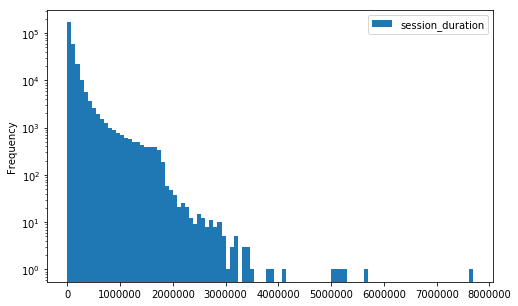

In [12]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5]);

## Scaling and clipping

Scale the duration by median and clip it to lie between [0,1]

In [15]:
%%bigquery

CREATE TEMPORARY FUNCTION CLIP_LESS(x FLOAT64, a FLOAT64) AS (
  IF (x < a, a, x)
);
CREATE TEMPORARY FUNCTION CLIP_GT(x FLOAT64, b FLOAT64) AS (
  IF (x > b, b, x)
);
CREATE TEMPORARY FUNCTION CLIP(x FLOAT64, a FLOAT64, b FLOAT64) AS (
  CLIP_GT(CLIP_LESS(x, a), b)
);
    
CREATE OR REPLACE TABLE advdata.ga360_recommendations_data
AS
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, we combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time ),
aggregate_web_stats AS (      
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0
),
normalized_session_duration AS (
    SELECT APPROX_QUANTILES(session_duration,100)[OFFSET(50)] AS median_duration
    FROM aggregate_web_stats
)
SELECT
   * EXCEPT(session_duration, median_duration),
   CLIP(0.3 * session_duration / median_duration, 0, 1.0) AS normalized_session_duration
FROM
   aggregate_web_stats, normalized_session_duration


In [19]:
%%bigquery df_scaled
SELECT * FROM advdata.ga360_recommendations_data

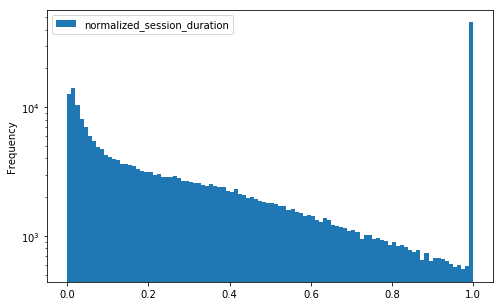

In [20]:
df_scaled[["normalized_session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5]);

In [21]:
df_scaled.head()

,visitorId,contentId,normalized_session_duration
0,4457498454949488072-1,709531,0.086414
1,5827168606555856601-2,709733,0.382719
2,5684576675894832060-2,709763,0.154013
3,5624735506447562560-2,710022,0.951807
4,1136161616016806175-1,710022,0.963775


In [ ]:
%%bash
cd ../flex_slots
./run_query_on_flex_slots.sh 

In [22]:
%%bigquery
SELECT 
  visitorId, 
  ARRAY_AGG(STRUCT(contentId, predicted_normalized_session_duration)
            ORDER BY predicted_normalized_session_duration DESC
            LIMIT 3)
FROM ML.RECOMMEND(MODEL advdata.ga360_recommendations_model)
WHERE predicted_normalized_session_duration < 1
GROUP BY visitorId
LIMIT 5

,visitorId,f0_
0,4589043051131287714-89,[{'predicted_normalized_session_duration': 0.9...
1,2149802163052546111-1,[{'predicted_normalized_session_duration': 0.9...
2,2158203819138491104-339,[{'predicted_normalized_session_duration': 0.9...
3,6926025071410055609-840,[{'predicted_normalized_session_duration': 0.9...
4,7517214078363009389-243,[{'predicted_normalized_session_duration': 0.9...


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License